In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
def get_mnist(limit = None):
    dt = pd.read_csv('C:\\Users\\Wei Guo\\Desktop\\data\\digit.csv')
    dt_value = dt.values
    X = dt_value[:,1:]
    Y = dt_value[:,0]
    if limit != None:
        X = X[:int(limit)]
        Y = Y[:int(limit)]
    return X,Y

In [5]:
st = tf.contrib.bayesflow.stochastic_tensor

In [6]:
Normal = tf.contrib.distributions.Normal

In [7]:
Bernoulli = tf.contrib.distributions.Bernoulli

In [32]:
class DenseLayer:
    def __init__(self,M1,M2,f=tf.nn.relu):
        self.W = tf.Variable(tf.random_normal(shape=(M1,M2))*2/np.sqrt(M1))
        self.b = tf.Variable(np.zeros(M2).astype(np.float32))
        self.f = f
    
    def forward(self,X):
        return self.f(tf.matmul(X,self.W)+self.b)

In [63]:
class VAE:
    def __init__(self, D, hidden_sizes):
        self.X = tf.placeholder(tf.float32,shape=(None,D))
        M_in = D
        
        #hidden-layers
        self.encode_layers = []
        for i in hidden_sizes[:-1]:
            M_out = i
            this_layer = DenseLayer(M1 = M_in, M2 = M_out)
            self.encode_layers.append(this_layer)
            M_in = M_out
            
        #hidden layer to Z
        M = int(hidden_sizes[-1])
        tem_layer = DenseLayer(M1 = M_in, M2 = 2*M,f = lambda x:x)
        self.encode_layers.append(tem_layer)
        
        #get the distribution of z
        current_value = self.X
        for layer in self.encode_layers:
            current_value = layer.forward(current_value)
        self.means = current_value[:,:M]
        self.sd = tf.nn.softplus(current_value[:,M:])
        
        #get sample from z
        with st.value_type(st.SampleValue()):
            self.Z = st.StochasticTensor(Normal(loc = self.means, scale = self.sd))
        
        self.decode_layers = []
        M_in = M
        for i in list(reversed(hidden_sizes[:-1])):
            M_out = i
            layer = DenseLayer(M1 = M_in, M2 = M_out)
            self.decode_layers.append(layer)
            M_in = M_out
        
        final_layer = DenseLayer(M1 = M_in, M2 = D, f = lambda x:x)
        self.decode_layers.append(final_layer)
        
        #get logits
        current_value = self.Z
        for layer in self.decode_layers:
            current_value = layer.forward(current_value)
        logits = current_value
        posterior_logits = logits
        
        self.X_hat = Bernoulli(logits=posterior_logits)
        self.posterior_predict = self.X_hat.sample()
        self.posterior_predict_probs = tf.nn.sigmoid(posterior_logits)
        
        #prior
        std_normal = Normal(
            loc = np.zeros(M,dtype=np.float32),
            scale = np.ones(M, dtype = np.float32)
        )
        Z_std = std_normal.sample(1)
        current_value = Z_std
        for layer in self.decode_layers:
            current_value = layer.forward(current_value)
        logits = current_value
        prior_logits = logits
        prior_distri = Bernoulli(logits = prior_logits)
        prior_predict = prior_distri.sample()
        prior_predict_probs = tf.nn.sigmoid(prior_logits)
        
        #cost
        k1 = tf.reduce_sum(tf.contrib.distributions.kl_divergence(self.Z.distribution,std_normal),1)
        loglike = -tf.nn.sigmoid_cross_entropy_with_logits(
            labels = self.X,
            logits = self.posterior_predict_probs
        )
        
        self.elbo = tf.reduce_sum(loglike - k1)
        self.trainop = tf.train.RMSPropOptimizer(learning_rate=0.0001).minimize(-self.elbo)
        
        self.init = tf.global_variables_initializer()
        self.sess = tf.InteractiveSession()
        self.sess.run(self.init)
    
    def fit(self,X, epi = 30, batch_size = 50):
        costs = []
        batch_num = int(X.shape[0]/batch_size)
        for i in range(epi):
            np.random.shuffle(X)
            for j in range(batch_num):
                X_batch = X[int(j*batch_size):int(j*batch_size+1)]
                _,c = self.sess.run((self.trainop,self.elbo),feed_dict={self.X:X_batch})
                c /= batch_size
                if j % 50 == 0:
                    costs.append(c)
        plt.plot(costs)
        plt.show()
    
    def sample(self,X):
        return self.sess.run(self.posterior_predict,feed_dict={self.X:X})

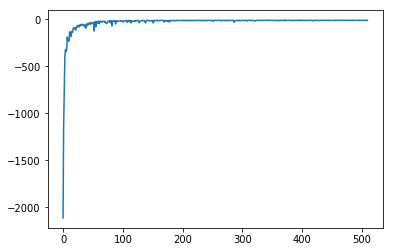

In [65]:
X,Y = get_mnist()
X = (X>0.5).astype(np.float32)

v = VAE(D=784,hidden_sizes=[200,100])
v.fit(X)

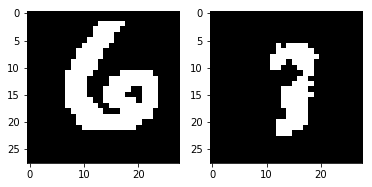

In [81]:
i = np.random.choice(len(X))
x = X[i]
pos_pre = v.sample([x]).reshape(28,28)
plt.subplot(1,2,1)
plt.imshow(x.reshape(28,28),cmap='gray')
plt.subplot(1,2,2)
plt.imshow(pos_pre,cmap='gray')
plt.show()